# Whale Optimization Algorithm
Whale Optimization Algorithm (WOA) is a recently proposed (2016) optimization algorithm mimicking the hunting mechanism of humpback whales in nature.
https://en.wikiversity.org/wiki/Whale_Optimization_Algorithm

## Imports

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import timeit
from tqdm import tqdm
import random
import math
import copy
import sys
import string
from collections import Counter

## Defining functions and algorithms to analyze

## Setting constants

In [32]:
max_n = 1500
mean_count=10
n = np.arange(1, max_n + 1, 1)

## Defining function to get execution time

In [11]:
def get_execution_time(algorithm, *args):
    start_time = timeit.default_timer()

    algorithm(*args)
        
    return timeit.default_timer() - start_time

## Get the execution time depending on size of input data 

In [20]:
def get_execution_time_array(algorithm, *args):
    times_array = []
    
    for n in tqdm(range (1, max_n +1)):
        execution_time_summ = 0
        
        for m in range(1, mean_count):
            execution_time_summ += get_execution_time(algorithm, *args)
            
        execution_time_mean = execution_time_summ / mean_count
        times_array.append(execution_time_mean)
        
    return np.array(times_array)

In [176]:
def get_execution_time_array_huffman(algorithm, *args):
    times_array = []
    
    for n in tqdm(range (1, max_n +1)):
        input_str = ''.join(random.choices(string.ascii_uppercase + string.digits, k=n))
        execution_time_summ = 0
        
        for m in range(1, mean_count):
            execution_time_summ += get_execution_time(algorithm, input_str, *args)
            
        execution_time_mean = execution_time_summ / mean_count
        times_array.append(execution_time_mean)
        
    return np.array(times_array)

## Plot Empirical and Theoretical time

In [24]:
def plot_time_graph(empirical, theoretical, name):
    fig, ax = plt.subplots()
    
    ax.plot(n, empirical, label = 'Empirical time')
    ax.plot(n, theoretical, label = 'Theoretical time')
    
    ax.set(xlabel='Array size', ylabel='Execution time',title=name)
    
    ax.legend()
    ax.grid()
    
    plt.show()

In [37]:
def plot_loss_convegence(loss, prams_history, bounds, optims):
  x = np.linspace(*bounds, 100)
  y = np.linspace(*bounds, 100)
  X, Y = np.meshgrid(x, y)
  Z = loss(X, Y)
  plt.contourf(X, Y, Z, levels=50, cmap='jet')
  prams_history = np.asarray(prams_history)
  plt.plot(prams_history[:, 0], prams_history[:, 1], '.-', color='w')
  for optim in optims:
    plt.plot(optim[0], optim[1], '*', color='r')
  plt.show()

# Part 1

In [170]:
class NodeTree(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right

    def children(self):
        return self.left, self.right

    def __str__(self):
        return self.left, self.right


def huffman_code_tree(node, binString=''):
    if type(node) is str:
        return {node: binString}
    (l, r) = node.children()
    d = dict()
    d.update(huffman_code_tree(l, binString + '0'))
    d.update(huffman_code_tree(r, binString + '1'))
    return d


def make_tree(nodes):
    while len(nodes) > 1:
        (key1, c1) = nodes[-1]
        (key2, c2) = nodes[-2]
        nodes = nodes[:-2]
        node = NodeTree(key1, key2)
        nodes.append((node, c1 + c2))
        nodes = sorted(nodes, key=lambda x: x[1], reverse=True)
    return nodes[0][0]

In [178]:
def huffman(input_str):
    freq = dict(Counter(input_str))
    freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    node = make_tree(freq)
    encoding = huffman_code_tree(node)

In [179]:
get_execution_time_array_huffman(huffman)

100%|██████████| 1500/1500 [00:07<00:00, 200.08it/s]


array([1.92099978e-05, 2.68200005e-05, 3.42000072e-05, ...,
       6.67790006e-04, 3.34059994e-04, 3.31790000e-04])

  3%|▎         | 50/1500 [00:00<00:02, 490.21it/s]

100%|██████████| 1500/1500 [00:07<00:00, 195.57it/s]


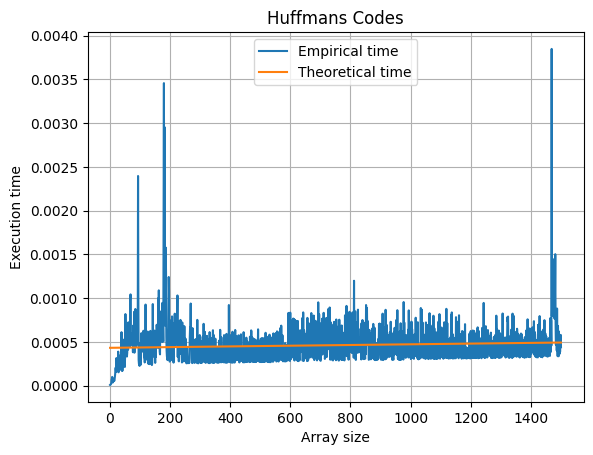

In [181]:
empirical_exec_time = get_execution_time_array_huffman(huffman)

coaf = np.polyfit(n, empirical_exec_time, 1)
polynom_fn = np.poly1d(coaf)

plot_time_graph(empirical_exec_time, polynom_fn(n), 'Huffmans Codes')

# Part 2

In [97]:
def fitness_rastrigin(position):
	fitness_value = 0.0
	for i in range(len(position)):
		xi = position[i]
		fitness_value += (xi * xi) - (10 * math.cos(2 * math.pi * xi)) + 10
	return fitness_value


def fitness_sphere(position):
	fitness_value = 0.0
	for i in range(len(position)):
		xi = position[i]
		fitness_value += (xi * xi)
	return fitness_value


class whale:
	def __init__(self, fitness, dim, minx, maxx, seed):
		self.rnd = random.Random(seed)
		self.position = [0.0 for i in range(dim)]

		for i in range(dim):
			self.position[i] = ((maxx - minx) * self.rnd.random() + minx)

		self.fitness = fitness(self.position) # curr fitness


# whale optimization algorithm(WOA)
def woa(fitness, max_iter, n, dim, minx, maxx, initial_guess):
	rnd = random.Random(0)

	params_history = [initial_guess]

	# create n random whales
	whalePopulation = [whale(fitness, dim, minx, maxx, i) for i in range(n)]

	# compute the value of best_position and best_fitness in the whale Population
	Xbest = initial_guess
	Fbest = sys.float_info.max

	for i in range(n): # check each whale
		if whalePopulation[i].fitness < Fbest:
			Fbest = whalePopulation[i].fitness
			Xbest = copy.copy(whalePopulation[i].position)

	# main loop of woa
	Iter = 0
	while Iter < max_iter:
		# linearly decreased from 2 to 0
		a = 2 * (1 - Iter / max_iter)
		a2=-1+Iter*((-1)/max_iter)

		for i in range(n):
			A = 2 * a * rnd.random() - a
			C = 2 * rnd.random()
			b = 1
			l = (a2-1)*rnd.random()+1
			p = rnd.random()

			D = [0.0 for i in range(dim)]
			D1 = [0.0 for i in range(dim)]
			Xnew = [0.0 for i in range(dim)]
			Xrand = [0.0 for i in range(dim)]
			if p < 0.5:
				if abs(A) > 1:
					for j in range(dim):
						D[j] = abs(C * Xbest[j] - whalePopulation[i].position[j])
						Xnew[j] = Xbest[j] - A * D[j]
				else:
					p = random.randint(0, n - 1)
					while (p == i):
						p = random.randint(0, n - 1)

					Xrand = whalePopulation[p].position

					for j in range(dim):
						D[j] = abs(C * Xrand[j] - whalePopulation[i].position[j])
						Xnew[j] = Xrand[j] - A * D[j]
			else:
				for j in range(dim):
					D1[j] = abs(Xbest[j] - whalePopulation[i].position[j])
					Xnew[j] = D1[j] * math.exp(b * l) * math.cos(2 * math.pi * l) + Xbest[j]

			for j in range(dim):
				whalePopulation[i].position[j] = Xnew[j]

		for i in range(n):
			# if Xnew < minx OR Xnew > maxx
			# then clip it
			for j in range(dim):
				whalePopulation[i].position[j] = max(whalePopulation[i].position[j], minx)
				whalePopulation[i].position[j] = min(whalePopulation[i].position[j], maxx)

			whalePopulation[i].fitness = fitness(whalePopulation[i].position)

			if (whalePopulation[i].fitness < Fbest):
				params_history.append(whalePopulation[i].position)
				Xbest = copy.copy(whalePopulation[i].position)
				Fbest = whalePopulation[i].fitness


		Iter += 1

	return Xbest, params_history

In [33]:
initial_guess = np.array([10,10], dtype=float)
fitness = fitness_sphere

empirical_exec_time = get_execution_time_array(woa, fitness, 100, 50, 2, -10.0, 10.0, initial_guess)

100%|██████████| 1500/1500 [23:18<00:00,  1.07it/s]


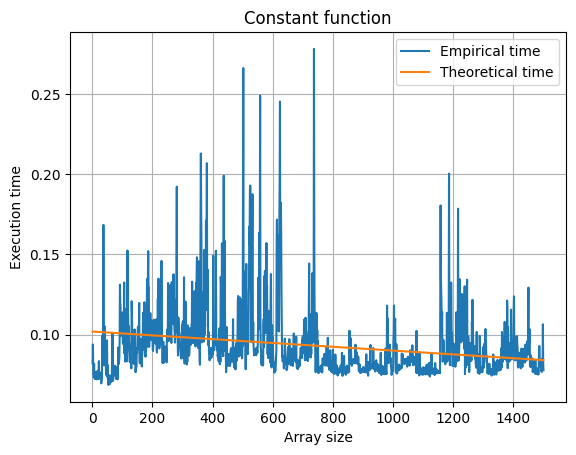

In [34]:
coaf = np.polyfit(n, empirical_exec_time, 1)
polynom_fn = np.poly1d(coaf)

plot_time_graph(empirical_exec_time, polynom_fn(n), 'Constant function')

# Let's try to use WOA to optimize various functions

# Parabolid

In [131]:
loss = lambda position: position[0]**2 + position[1]**2
initial_guess = np.array([7,7], dtype=float)
global_opt = [0.0, 0.0]
min_lim = -10.0
max_lim =  10.0

In [138]:
dim = 2
num_whales = 20
max_iter = 10

best_position, params_history = woa(loss, max_iter, num_whales, dim, min_lim, max_lim, initial_guess)
err = loss(best_position)

In [139]:
print(f'Known global optimum {global_opt}')
print(f'Global loss value {loss(global_opt)}')
print(f'Predicted optimum {best_position}')
print(f'Predicted loss value {err}')
print(f'Accuracy = {(loss(global_opt) - err)**2}')

Known global optimum [0.0, 0.0]
Global loss value 0.0
Predicted optimum [0.09707009167791464, 0.015114618402785732]
Predicted loss value 0.009651054387820582
Accuracy = 9.31428507966709e-05


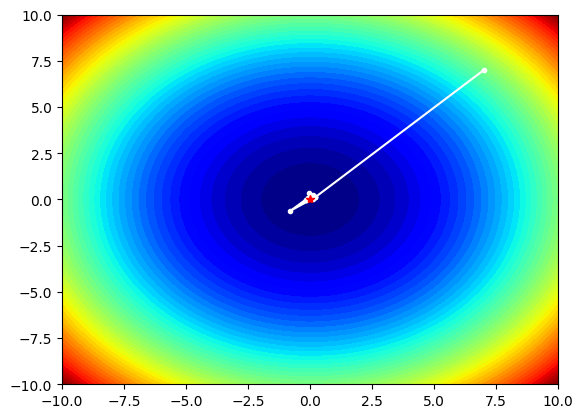

In [140]:
loss_fun = lambda x, y: x**2 + y**2
plot_loss_convegence(loss_fun, params_history, [min_lim, max_lim], [global_opt])

# Himmelblau

In [109]:
loss = lambda position: (position[0]**2 + position[1] - 11)**2 + (position[0] + position[1]**2 - 7)**2
global_optims = [[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]]
initial_guess = np.array([0, 0])

In [127]:
dim = 2
num_whales = 20
max_iter = 10

best_position, params_history = woa(loss, max_iter, num_whales, dim, min_lim, max_lim, initial_guess)
err = loss(best_position)
best_position

[2.8713159674239965, 2.213584659135871]

In [128]:
difference_array = np.square(np.array(global_optims) - np.array(best_position))
sum_square = np.sum(difference_array)
index = sum_square.argmin()

global_opt = global_optims[index]
global_loss_value = loss(global_opt)

print(f'Known global optimum {global_opt}')
print(f'Global loss value {global_loss_value}')
print(f'Predicted optimum {best_position}')
print(f'Predicted loss value {err}')
print(f'Accuracy = {(global_loss_value - err)**2}')

Known global optimum [3.0, 2.0]
Global loss value 0.0
Predicted optimum [2.8713159674239965, 2.213584659135871]
Predicted loss value 0.8885826508522539
Accuracy = 0.7895791273956184


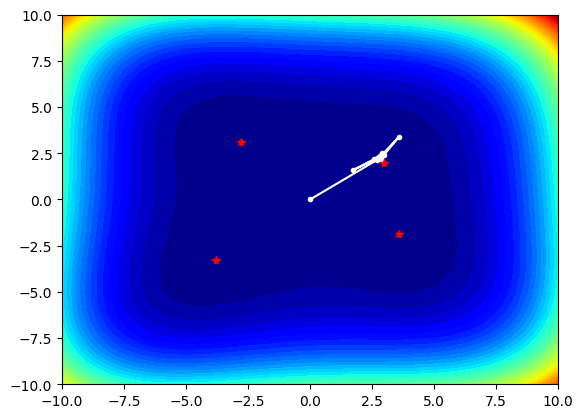

In [129]:
loss_fun = lambda x, y: (x**2 + y - 11)**2 + (x + y**2 - 7)**2
plot_loss_convegence(loss_fun, params_history, [min_lim, max_lim], global_optims)

# Ackley

In [154]:
global_opt = [0.0, 0.0]
initial_guess = np.array([-4,-4])
loss = lambda position: -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (position[0]**2 + position[1]**2))) - np.exp(0.5 * (np.cos(2 * np.pi * position[0]) + np.cos(2 * np.pi * position[1]))) + np.e + 20

In [151]:
dim = 2
num_whales = 20
max_iter = 10

best_position, params_history = woa(loss, max_iter, num_whales, dim, min_lim, max_lim, initial_guess)
err = loss(best_position)
best_position

[0.028359474620454357, -0.008044411676994441]

In [152]:
print(f'Known global optimum {global_opt}')
print(f'Global loss value {loss(global_opt)}')
print(f'Predicted optimum {best_position}')
print(f'Predicted loss value {err}')
print(f'Accuracy = {(loss(global_opt) - err)**2}')

Known global optimum [0.0, 0.0]
Global loss value 0.0
Predicted optimum [0.028359474620454357, -0.008044411676994441]
Predicted loss value 0.10636028732520231
Accuracy = 0.011312510719899591


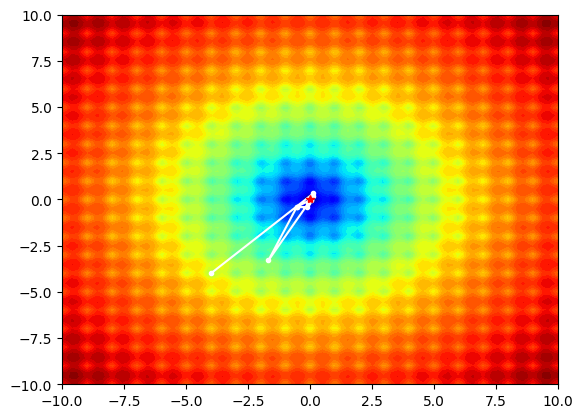

In [155]:
loss_fun = lambda x,y: -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20
plot_loss_convegence(loss_fun, params_history, [min_lim, max_lim], [global_opt])